# Exploring the LPD-Cleansed Dataset

## Configurations

In [131]:
%matplotlib inline
import os
import json
import errno
import random
import warnings
import numpy as np
import scipy.signal
import pretty_midi
import joblib
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [162]:
# Deal with the bold roman font bug, see
#   https://github.com/matplotlib/matplotlib/issues/5574
matplotlib.font_manager._rebuild()
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 10.0
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['savefig.dpi'] = 150

In [47]:
lpd_root = "/home/salu133445/NAS/salu133445/lpd/lpd/lpd_cleansed/"
id_path = "/home/salu133445/NAS/salu133445/lpd/cleansed_ids.txt"
id_lists_root = "/home/salu133445/NAS/salu133445/git/musegan/preprocessing/id_lists"
result_dir = "./figs/"
extension = 'png' # 'pdf', 'ps', 'eps', 'svg'

In [32]:
with open(id_path) as f:
    id_md5 = {line.split()[1]: line.split()[0] for line in f}

## Utility Functions

In [33]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def get_npz_path(msd_id):
    return os.path.join(lpd_root, msd_id[2], msd_id[3], msd_id[4], msd_id,
                        id_md5[msd_id] + '.npz')

def get_multitrack(msd_id):
    return Multitrack(get_npz_path(msd_id))

In [40]:
make_sure_path_exists(result_dir)

## Visualizations of Multi-track Piano-rolls in the Dataset

In [34]:
m = get_multitrack(random.choice(list(id_md5.keys())))

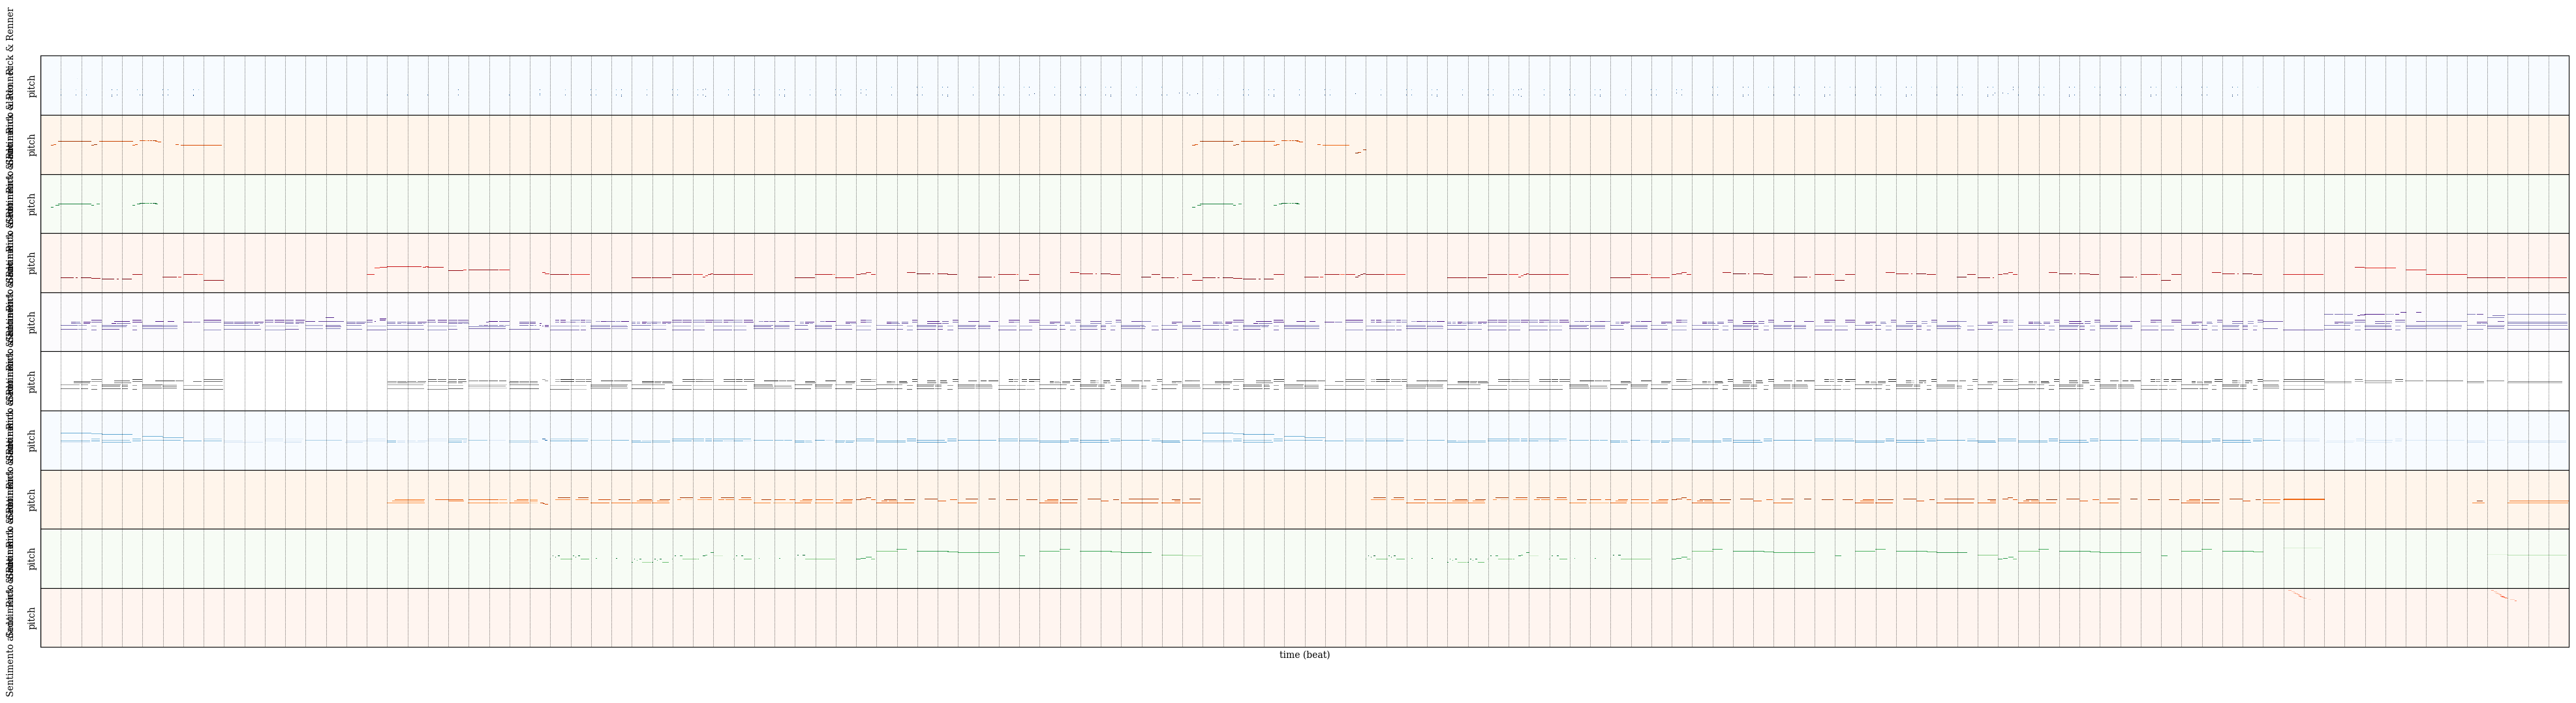

In [38]:
fig, axs = m.plot(preset='frame', grid='x')
plt.minorticks_off()
num_beat = m.tracks[0].pianoroll.shape[0] // m.beat_resolution // 4
xticks_major = 4 * m.beat_resolution * np.arange(0, num_beat)
for ax in axs:
    ax.set_xticks(xticks_major)
fig.set_size_inches(50, 12)
plt.show()

### Run for 10 times and save the results

In [45]:
def batch_visualize(times):
    for i in range(times):
        m = get_multitrack(random.choice(list(id_md5.keys())))
        fig, axs = m.plot(preset='frame', grid='x')
        plt.minorticks_off()
        num_beat = m.tracks[0].pianoroll.shape[0] // m.beat_resolution // 4
        xticks_major = 4 * m.beat_resolution * np.arange(0, num_beat)
        for ax in axs:
            ax.set_xticks(xticks_major)
        fig.set_size_inches(50, 12)
        plt.savefig(os.path.join(result_dir, "{}.{}".format(i, extension)))
        plt.close()

In [ ]:
# batch_visualize(10)

## Dataset Statistics

In [46]:
print("# of songs:", len(id_md5))

# of songs: 21425


### Tag Statistics

In [117]:
tag_sources = ('lastfm', 'magd', 'tagtraum')
tag_lists = {tag_source: {} for tag_source in tag_sources}
for tag_source in tag_sources:
    for f in os.listdir(os.path.join(id_lists_root, tag_source)):
        filepath = os.path.join(id_lists_root, tag_source, f)
        if os.path.isfile(filepath):
            tag = os.path.basename(f)[(len(tag_source) + 1):-3]
            tag_list = open(filepath).read().splitlines()
            if len(tag_list) > 0:
                tag_lists[tag_source][tag] = tag_list

tag_counts = {tag_source: {key: len(value)
                           for key, value in tag_lists[tag_source].items()}
              for tag_source in tag_sources}

In [118]:
# for key in tag_lists['lastfm']:
#     print("{:20} {}".format(key, len(tag_lists['lastfm'][key])))

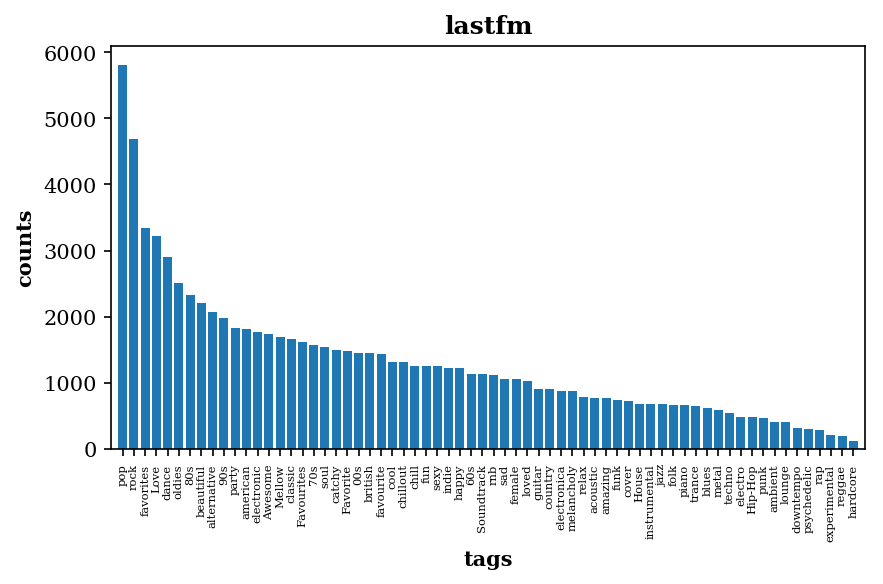

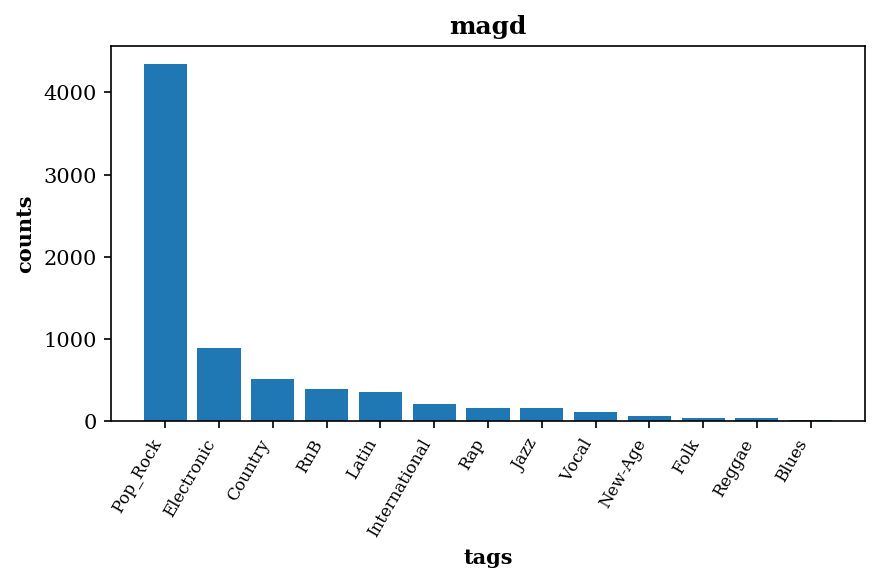

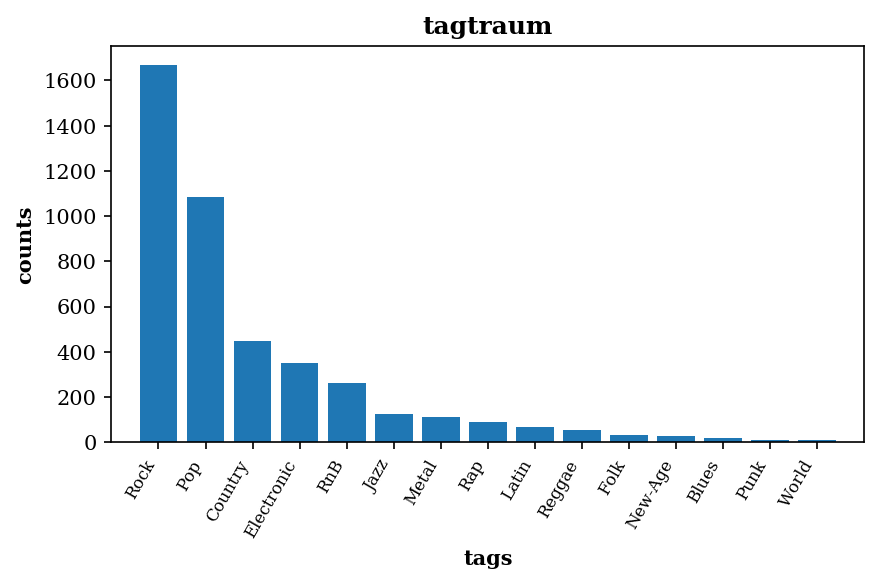

In [223]:
for tag_source in tag_sources:
    sorted_key = sorted(tag_counts[tag_source], key=tag_counts[tag_source].get, reverse=True)
    plt.bar(range(len(sorted_key)), [tag_counts[tag_source][key] for key in sorted_key], align='center')
    if tag_source == 'lastfm':
        kwargs = {'fontsize': 5.5, 'rotation': 90}
    else:
        kwargs = {'fontsize': 8, 'rotation': 60, 'ha': 'right'}
    plt.xticks(range(len(sorted_key)), sorted_key, **kwargs)
    plt.title(tag_source)
    plt.xlabel('tags')
    plt.ylabel('counts')
    plt.xlim(-1, len(tag_counts[tag_source]))
    plt.tight_layout()
    plt.savefig(os.path.join(result_dir, "tag_counts_{}.{}".format(tag_source, extension)))
    plt.show()

### Multi-track Piano-roll Statistics

In [137]:
def get_id_info_pair(msd_id):
    with np.load(get_npz_path(msd_id)) as loaded:
        info_dict = json.loads(loaded['info.json'].decode('utf-8'))
        info_dict['length'] = loaded['pianoroll_0_csc_shape'][0] // 96
    return (msd_id, info_dict)

In [138]:
id_info_pairs = joblib.Parallel(n_jobs=30)(
    joblib.delayed(get_id_info_pair)(msd_id)
    for msd_id in id_md5.keys())
multitrack_info = dict(id_info_pairs)

In [142]:
lengths = []
num_tracks = []
program_counts = [0] * 128
for info_dict in multitrack_info.values():
    idx = 0
    while str(idx) in info_dict:
        program_counts[info_dict[str(idx)]['program']] += 1
        idx += 1
    num_tracks.append(idx)
    lengths.append(info_dict['length'])

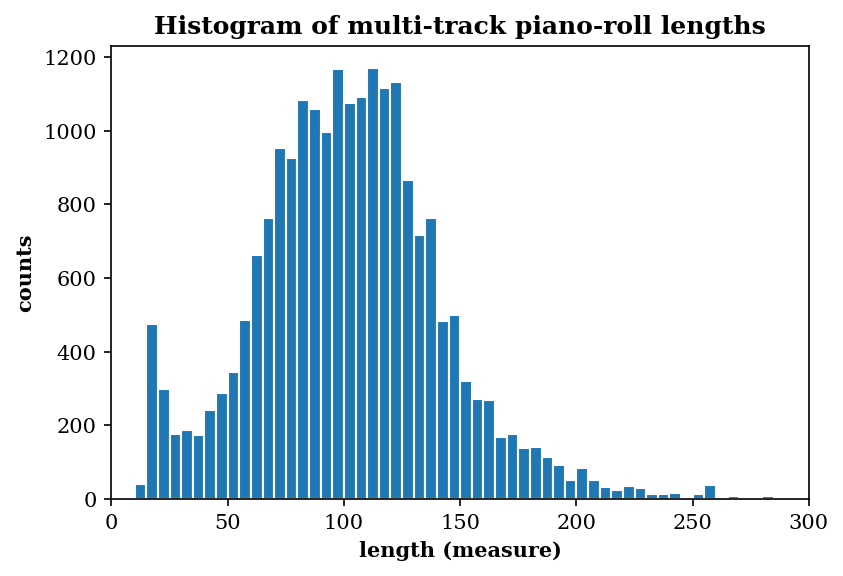

In [327]:
plt.hist(lengths, np.arange(0, 300, 5), range=(0, 300), linewidth=1., edgecolor='w')
plt.title('Histogram of multi-track piano-roll lengths')
plt.xlabel('length (measure)')
plt.ylabel('counts')
plt.xlim(0, 300)
plt.savefig(os.path.join(result_dir, "hist_length.{}".format(extension)))
plt.show()

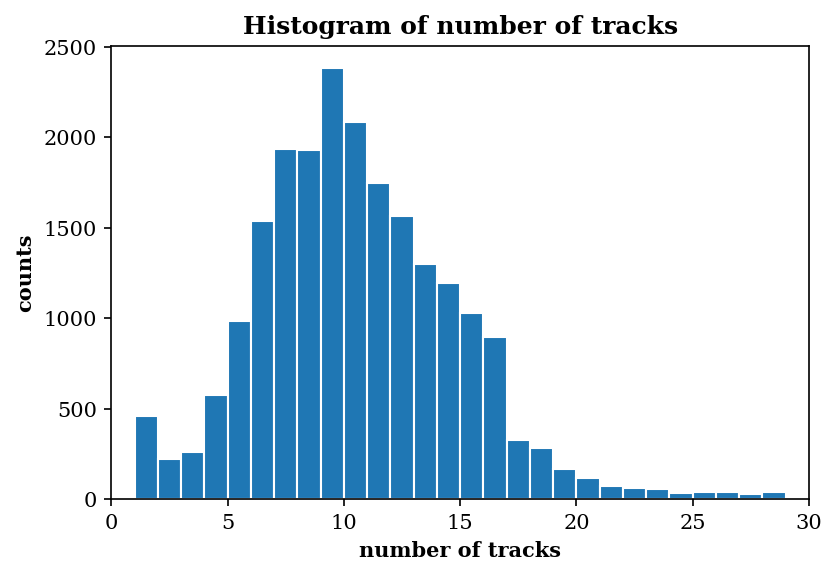

In [326]:
plt.hist(num_tracks, np.arange(0, 30, 1), linewidth=1., edgecolor='w')
plt.title('Histogram of number of tracks')
plt.xlabel('number of tracks')
plt.ylabel('counts')
plt.xlim(0, 30)
plt.savefig(os.path.join(result_dir, "hist_num_track.{}".format(extension)))
plt.show()

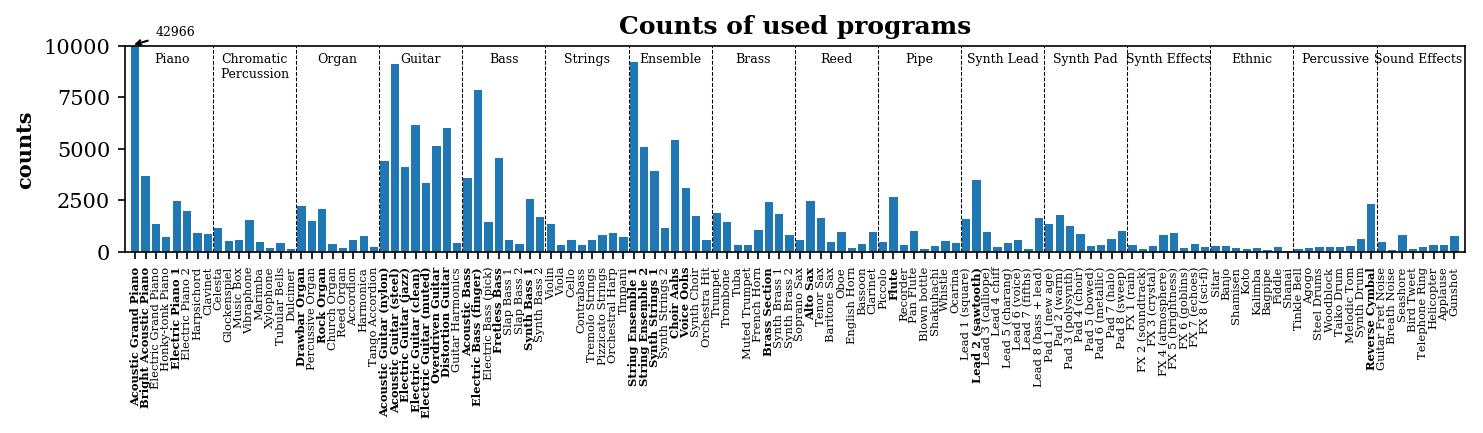

In [309]:
plt.bar(range(len(program_counts)), program_counts, align='center')
plt.gcf().set_size_inches(10, 3)
th = 2000
plt.xticks(range(len(program_counts)), pretty_midi.INSTRUMENT_MAP,
           fontsize=5.5, rotation=90)
for idx in np.nonzero(np.array(program_counts) > th)[0]:
    plt.gca().get_xticklabels()[idx].set_weight("bold")
#     plt.gca().get_xticklabels()[idx].set_color("xkcd:dark blue")
plt.title('Counts of used programs')
plt.ylabel('counts')
plt.xlim(-1, len(program_counts))
plt.ylim(0, 10000)
for i in range(16):
    if i < 15:
        plt.axvline(7.5 + i * 8, color='k', linestyle='--', linewidth=.5)
    if i != 1:
        s = pretty_midi.INSTRUMENT_CLASSES[i]
    else:
        s = '\n'.join(pretty_midi.INSTRUMENT_CLASSES[i].split())
    plt.text(3.5 + i * 8, 9700, s, fontsize=6,
             horizontalalignment='center', verticalalignment='top')
plt.annotate('42966', xy=(-.5, 10000), xytext=(2, 10500), fontsize=6,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.tight_layout()
plt.savefig(os.path.join(result_dir, "program_counts.{}".format(extension)))
plt.show()